# Nelder-Mead Generator adapted from SciPy

Most of the algorithms in scipy.optimize are self-contained functions that operate on the user-provided `func`. Xopt has adapted the Nelder-Mead directly from scipy.optimize to be in a generator form. This allows for the manual stepping through the algorithm.


In [1]:
from xopt import Xopt
import numpy as np

#from xopt import output_notebook
#output_notebook()

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Nelder-Mead optimization of the Rosenbrock function with Xopt

In [2]:
YAML = """
xopt: {}
generator:
  name: neldermead
  initial_point: {x0: -1, x1: -1}
  adaptive: true
  xatol: 0.0001
  fatol: 0.0001  
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x0: [-5, 5]
    x1: [-5, 5]
  objectives: {y: MINIMIZE}
"""
X = Xopt(YAML)

In [3]:
XMIN = [1,1] # True minimum

In [4]:
# Test 
X.evaluate({"x0":XMIN[0], "x1": XMIN[1]})

{'y': 0}

In [5]:
X.run()
X.data

,x0,x1,y,xopt_error,xopt_error_str
1,-1.000000,-1.000000,4.040000e+02,False,
2,-1.050000,-1.000000,4.462531e+02,False,
3,-1.000000,-1.050000,4.242500e+02,False,
4,-0.950000,-1.050000,3.850281e+02,False,
5,-0.900000,-1.075000,3.589325e+02,False,
...,...,...,...,...,...
122,0.999877,0.999764,2.587916e-08,False,
123,0.999999,0.999995,5.309344e-10,False,
124,1.000045,1.000097,7.751675e-09,False,
125,0.999963,0.999925,1.412126e-09,False,


Text(0, 0.5, 'Rosenbrock value')

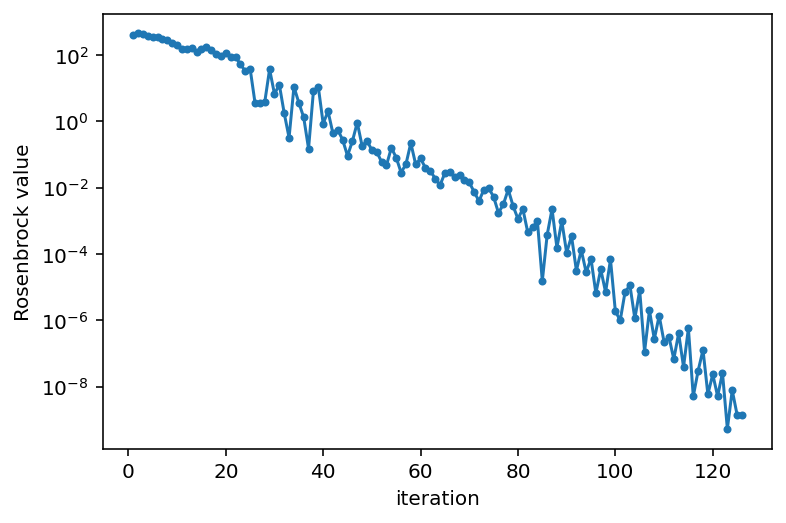

In [6]:
# Evaluation progression
X.data['y'].plot(marker='.')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')

In [7]:
# Minimum
dict(X.data.iloc[X.data["y"].argmin()])

{'x0': 0.9999988592114838,
 'x1': 0.9999954170486077,
 'y': 5.309343918637161e-10,
 'xopt_error': False,
 'xopt_error_str': ''}

## Visualize

In [8]:
from xopt.resources.test_functions.rosenbrock import rosenbrock

Text(0.5, 1.0, "Xopt's Nelder-Mead progression")

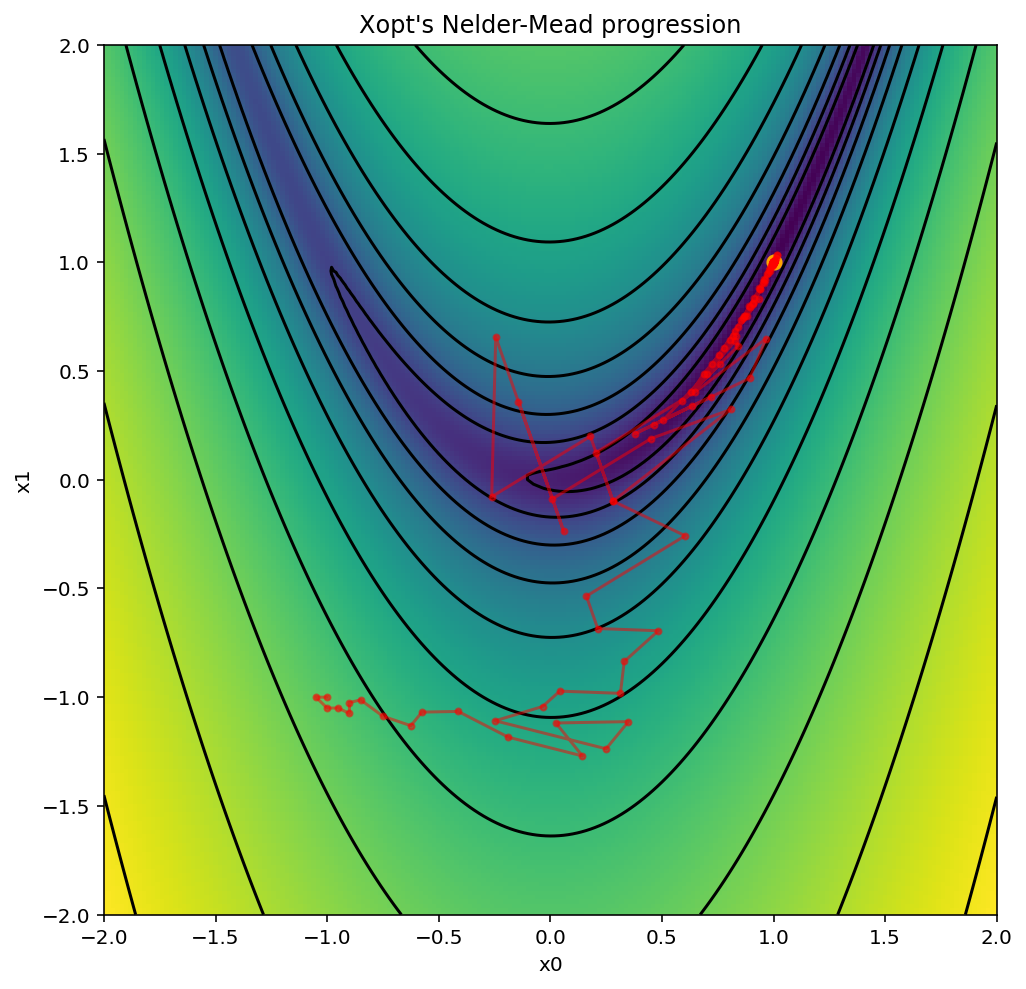

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201) )

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y]))(Xgrid, Ygrid)
Zgrid = np.log(Zgrid+1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')


# Add all evaluations
ax.plot(X.data["x0"], X.data["x1"], color='red', alpha=0.5, marker='.')
ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
#plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")

In [10]:
# Manually step the algorithm and collect simplexes
X = Xopt(YAML)
simplexes = []
while not X.is_done:
    X.step()
    simplexes.append(X.generator.simplex)


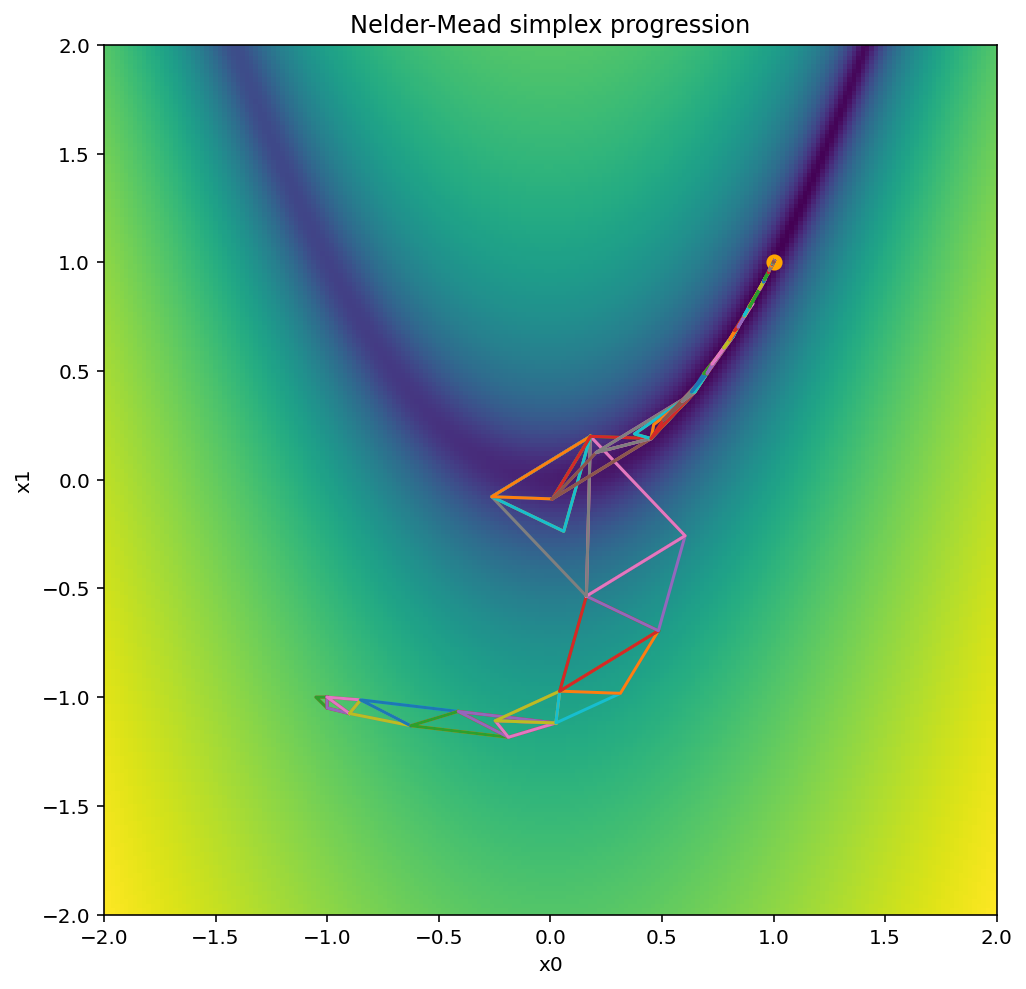

In [11]:
def plot_simplex(simplex, ax=None):
    x0 = simplex["x0"]
    x1 = simplex["x1"]
    x0 = np.append(x0, x0[0])
    x1 = np.append(x1, x1[0])
    ax.plot(x0, x1)

fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(Xgrid, Ygrid, Zgrid)
#ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)  
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_title('Nelder-Mead simplex progression')

ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")

for simplex in simplexes:
    plot_simplex(simplex, ax)

## Compare with scipy.optimize.fmin Nelder-Mead

Notice that fmin is much faster here. This is because the function runs very fast, so the internal Xopt bookkeeping overhead dominates.


In [12]:
from scipy.optimize import fmin

In [13]:
%%time
result = fmin(rosenbrock, [-1, -1])
result

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 125
CPU times: user 3.79 ms, sys: 2.67 ms, total: 6.46 ms
Wall time: 2.56 ms


array([0.99999886, 0.99999542])

In [14]:
X = Xopt(YAML)

In [15]:
%%time
X.run()
# Almost exactly the same number evaluations. 
len(X.data) 

CPU times: user 148 ms, sys: 11.3 ms, total: 159 ms
Wall time: 150 ms


126

In [16]:
# results are the same
xbest = X.data.iloc[X.data["y"].argmin()]
xbest['x0'] == result[0], xbest['x1'] == result[1]

(True, True)

# NelderMeadGenerator object

In [17]:
from xopt.generators.scipy.neldermead import NelderMeadGenerator
from xopt import Evaluator, VOCS

In [18]:
# default options
NelderMeadGenerator.default_options()

NelderMeadOptions(initial_point=None, initial_simplex=None, adaptive=True, xatol=0.0001, fatol=0.0001)

In [19]:
Xbest = [33, 44]

def f(inputs, verbose=False):

    if verbose:
        print(f'evaluate f({x})')
    x0 = inputs["x0"]
    x1 = inputs["x1"]
    
    #if x0 < 10:
    #    raise ValueError('test XXXX')

    y = (x0-Xbest[0])**2  + (x1-Xbest[1])**2

    return {"y":y}

ev = Evaluator(function=f)
vocs = VOCS(variables={"x0": [-100, 100], "x1": [-100,100]}, objectives={"y":"MINIMIZE"})
vocs.json()

'{"variables": {"x0": [-100.0, 100.0], "x1": [-100.0, 100.0]}, "constraints": {}, "objectives": {"y": "MINIMIZE"}, "constants": {}, "linked_variables": {}}'

In [20]:
# check output
f(vocs.random_inputs())

{'y': 712.5293096805891}

In [21]:
G = NelderMeadGenerator(vocs)
G.generate(1)

[{'x0': -97.67786992157866, 'x1': -29.887321186042556}]

In [22]:
# This will throw an exception 
try:
    G.generate(1)
except Exception as ex:
    print(ex)

Generation is locked via ._lock. Please call `add_data` before any further generate(1)


In [23]:
# This will unlock
G.add_data([ev.evaluate(G.inputs[0])])
G.generate(1)

[{'x0': -100.0, 'x1': -29.887321186042556}]

In [24]:
# Create Xopt object
X = Xopt(evaluator=ev, vocs=vocs, generator=NelderMeadGenerator(vocs=vocs))

# Optional: give an initial pioint
X.generator.initial_point = {'x0':0, 'x1':0}

In [25]:
X.run()

In [26]:
# This shows the latest simplex
X.generator.simplex

{'x0': array([32.99996111, 32.99996171, 33.00002688]),
 'x1': array([44.00000851, 44.00006811, 44.00003045])}

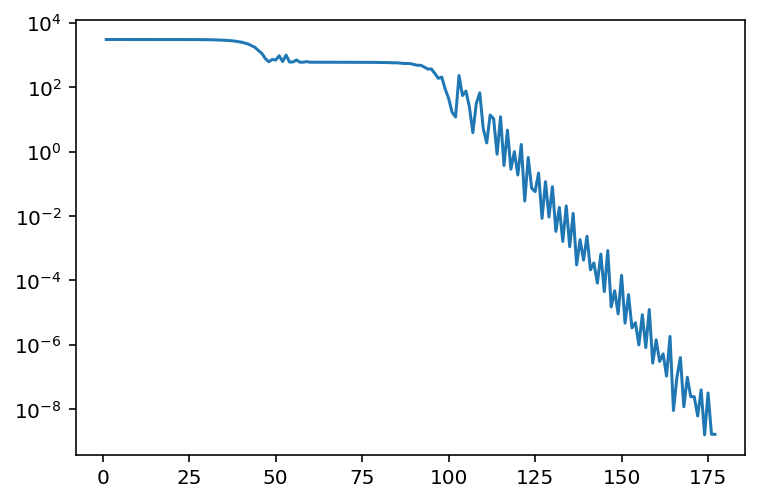

In [27]:
X.data['y'].plot()
plt.yscale('log')

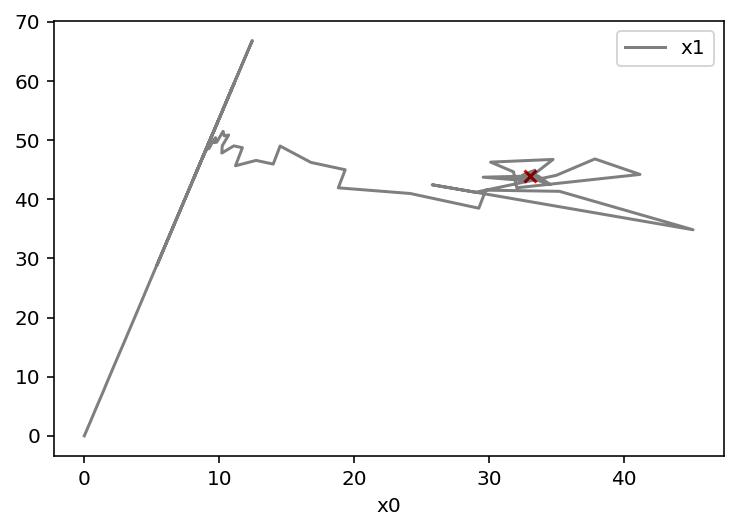

In [28]:
fig, ax = plt.subplots()
X.data.plot('x0', 'x1', ax=ax, color='black', alpha=0.5)
ax.scatter(Xbest[0], Xbest[1], marker='x', color='red')    

In [29]:
# This is the raw internal simplex points
a = X.generator.state
a

array([[32.99996111, 44.00000851],
       [32.99996171, 44.00006811],
       [33.00002688, 44.00003045]])

In [30]:
# Check JSON representation of options
X.generator.options.json()

'{"initial_point": {"x0": 0, "x1": 0}, "initial_simplex": null, "adaptive": true, "xatol": 0.0001, "fatol": 0.0001}'

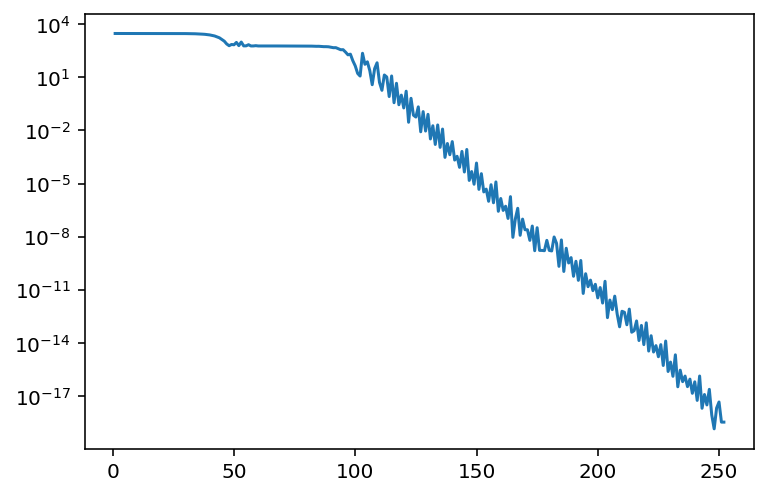

In [31]:
# Set the initial simplex to be the latest, 
X.generator.options.initial_simplex = X.generator.simplex
X.generator.options.xatol = 1e-9
X.generator.options.fatol = 1e-9
X.generator._is_done = False # Unlock
X.run()


X.data['y'].plot()
plt.yscale('log')

## 5-dimensional Rosenbrock

`evaluate_rosenbrock` works for arbitrary dimensions, so adding more variables to `vocs` transforms this problem.

In [32]:
YAML = """
xopt: {}
generator:
  name: neldermead
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x1: [-5, 5]
    x2: [-5, 5]
    x3: [-5, 5]
    x4: [-5, 5]
    x5: [-5, 5]
  objectives:
    y: MINIMIZE
"""
X = Xopt(YAML)

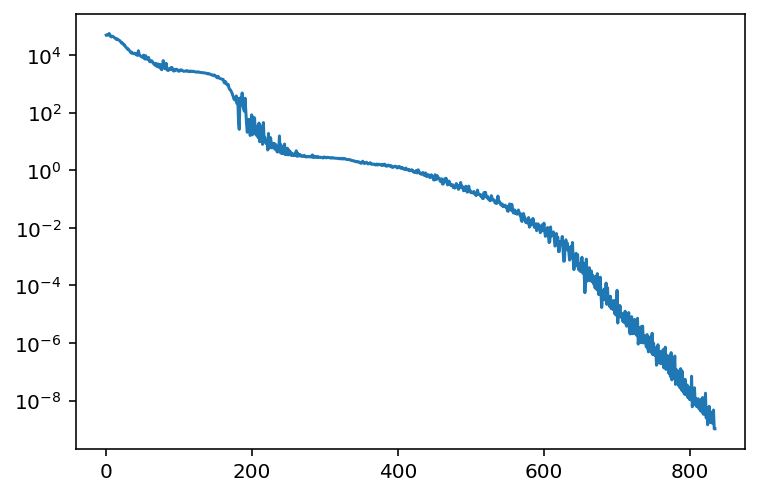

In [33]:
X.run()
X.data['y'].plot()
plt.yscale('log')

Text(0.5, 1.0, "Xopt's Nelder-Mead progression")

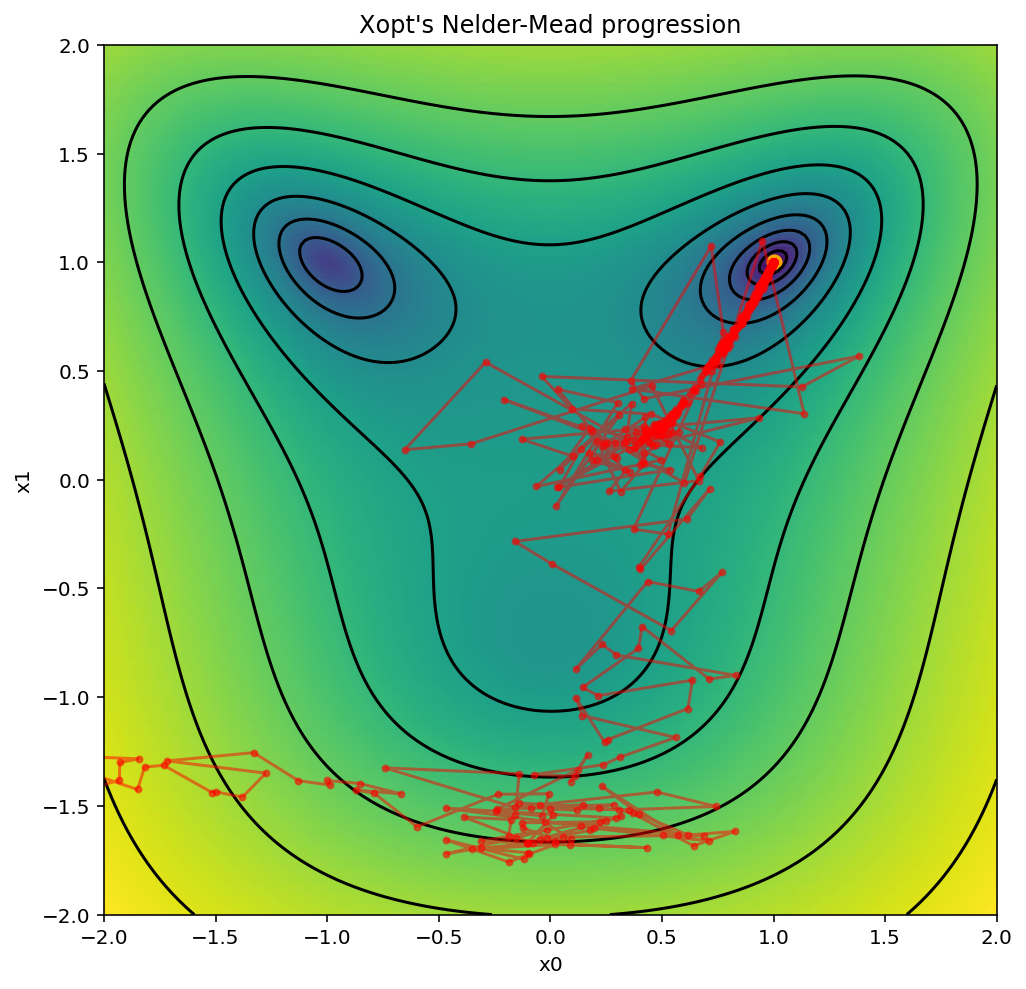

In [34]:
fig, ax = plt.subplots(figsize=(8,8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201) )

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y, 1, 1, 1]))(Xgrid, Ygrid)  # The minimum is at 1,1,1,1,1
Zgrid = np.log(Zgrid+1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')


# Add all evaluations
ax.plot(X.data["x1"], X.data["x2"], color='red', alpha=0.5, marker='.')
ax.scatter(XMIN[0], XMIN[1], 50, marker='o', color='orange', label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
#plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")